Sheet 8.1: An LSTM-based image captioner for the annotated 3D-Shapes data set
=============================================================================

**Author:** Michael Franke & Polina Tsvilodub



In order to see how a custom-built neural image captioning (NIC) system can be implemented and used for inference, we look here at a relatively simple LSTM-based image captioner.
To shortcut the time it takes for training this model, we use downloadable weights from a trained version of this model.
The goal is to see the architecture in full detail and to get a feeling for the way in which images and text data is handled during inference.
Most importantly, however, we will want to get a feeling for how good the model&rsquo;s predictions are, at least intuitively.

This tutorial uses a synthetic data set of annotations for the [3D Shapes data set](https://github.com/deepmind/3d-shapes), which we will refer to as &ldquo;annotated 3D Shapes data set&rdquo; or &ldquo;A3DS&rdquo; for short.
Other image-captioning data sets (like MS-Coco) contain heterogeneous pictures and often only a small number of captions per picture, making it less clear whether it is the NIC&rsquo;s fault or the potentially poor quality of the data set that causes generations to be intuitively inadequate (garbled, untrue, over- or underspecified &#x2026;).
In contrast, using the A3DS data set, makes it easier to judge, on intuitive grounds, whether generated captions are any good.



## Credits and origin of material



The material presented in this tutorial is in large part based on work conducted by Polina Tsvilodub for her 2022 MSc thesis &ldquo;Language Drift of Multi-Agent Communication Systems in Reference Games&rdquo;.
In particular, the annotated 3D Shapes data set and the LSTM-based architecture stems from this thesis.



## Necessary files



You need additional files to run the code in this notebook.
If you are on CoLab use these commands to install.
(Check if the files are installed in the right directory (&rsquo;A3DS&rsquo;) after unzipping).



In [1]:
# !wget https://github.com/michael-franke/npNLG/raw/main/neural_pragmatic_nlg/data/A3DS/A3DS.zip
# !unzip A3DS.zip

## Packages



On top of the usual suspects, we will use the &rsquo;Image&rsquo; and &rsquo;torchvision&rsquo; package to process image data.
We need package &rsquo;pickle&rsquo; to load image data and pre-trained model weights.



In [1]:
##################################################
## import packages
##################################################

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchtext.data import get_tokenizer
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import random
from random import shuffle
# from tqdm import tqdm
import pickle
# import 5py

import warnings
warnings.filterwarnings('ignore')

## The A3DS data set



The following code gives us PyTorch &rsquo;Dataset&rsquo; and &rsquo;DataLoader&rsquo; objects, with which to handle a 1k-subset of images and annotations from the A3DS data set.



### The &rsquo;Dataset&rsquo; object



Here is the definition of the &rsquo;Dataset&rsquo; object.



In [1]:
class A3DS(Dataset):
    """
    Dataset class for loading the dataset of images and captions from the 3dshapes dataset.

    Arguments:
    ---------
    num_labels: int
        Number of distinct captions to sample for each image. Relevant for using the dataloader for training models.
    labels_type: str
        "long" or "short". Indicates whether long or short captions should be used.
    run_inference: bool
        Flag indicating whether this dataset will be used for performing inference with a trained image captioner.
    batch_size: int
        Batch size. Has to be 1 in order to save the example image-caption pairs.
    vocab_file: str
        Name of vocab file.
    start_token: str
        Start token.
    end_token: str
        End token.
    unk_token: str
        Token to be used when encoding unknown tokens.
    pad_token: str
        Pad token to be used for padding captions tp max_sequence_length.
    max_sequence_length: int
        Length to which all captions are padded / truncated.
    """
    def __init__(
            self,
            path="A3DS",
            num_labels=1, # number of ground truth labels to retrieve per image
            labels_type="long", # alternative: short
            run_inference=False, # depending on this flag, check presence of model weights
            batch_size=1,
            vocab_file="vocab.pkl",
            start_token="START",  # might be unnecessary since vocab file is fixed anyways
            end_token="END",
            unk_token="UNK",
            pad_token="PAD",
            max_sequence_length=26, # important for padding length
        ):

        # check vocab file exists
        assert os.path.exists(os.path.join(path, vocab_file)), "Make sure the vocab file exists in the directory passed to the dataloader (see README)"

        # check if image file exists
        assert (os.path.exists(os.path.join(path, "sandbox_3Dshapes_1000.pkl")) and os.path.join(path, "sandbox_3Dshapes_resnet50_features_1000.pt")), "Make sure the sandbox dataset exists in the directory passed to the dataloader (see README)"

        if labels_type == "long":
            assert num_labels <= 20, "Maximally 20 distinct image-long caption pairs can be created for one image"
        else:
            assert num_labels <= 27, "Maximally 27 distinct image-short caption pairs can be created for one image"

        self.batch_size = batch_size
        with open(os.path.join(path, vocab_file), "rb") as vf:
            self.vocab = pickle.load(vf)

        self.max_sequence_length = max_sequence_length
        self.start_token = start_token
        self.end_token = end_token
        self.unk_token = unk_token
        self.pad_token = pad_token
        self.tokenizer = get_tokenizer("basic_english")

        self.embedded_imgs = torch.load(os.path.join(path, "sandbox_3Dshapes_resnet50_features_1000.pt"))
        with open(os.path.join(path, "sandbox_3Dshapes_1000.pkl"), "rb") as f:
            self.sandbox_file = pickle.load(f)
            self.images = self.sandbox_file["images"]
            self.numeric_labels = self.sandbox_file["labels_numeric"]
            self.labels_long = self.sandbox_file["labels_long"]
            self.labels_short = self.sandbox_file["labels_short"]

        if labels_type == "long":
            labels_ids_flat = [list(np.random.choice(range(len(self.labels_long[0])), num_labels, replace=False)) for i in range(len(self.images))]
            self.labels_flat = [self.labels_long[i][l] for i, sublst in enumerate(labels_ids_flat) for l in sublst]
            self.img_ids_flat = [id for id in range(len(self.images)) for i in range(num_labels)]
        else:
            labels_ids_flat = [list(np.random.choice(range(len(self.labels_short[0])), num_labels, replace=False)) for i in range(len(self.images))]
            self.labels_flat = [self.labels_short[i][l] for i, sublst in enumerate(labels_ids_flat) for l in sublst]
            self.img_ids_flat = [id for id in range(len(self.images)) for i in range(num_labels)]

        # print("len labels ids flat ", len(labels_ids_flat))
        # print("len labels flat ", len(self.labels_flat), self.labels_flat[:5])
        # print("len image ids flat ", len(self.img_ids_flat), self.img_ids_flat[:5])

    def __len__(self):
        """
        Returns length of dataset.
        """
        return len(self.img_ids_flat)

    def __getitem__(self, idx):
        """
        Iterator over the dataset.

        Arguments:
        ---------
        idx: int
            Index for accessing the flat image-caption pairs.

        Returns:
        -------
        target_img: np.ndarray (64,64,3)
            Original image.
        target_features: torch.Tensor(2048,)
            ResNet features of the image.
        target_lbl: str
            String caption.
        numeric_lbl: np.ndarray (6,)
            Original numeric image annotation.
        target_caption: torch.Tensor(batch_size, 25)
            Encoded caption.
        """
        # access raw image corresponding to the index in the entire dataset
        target_img = self.images[self.img_ids_flat[idx]]
        # access caption
        target_lbl = self.labels_flat[idx]
        # access original numeric annotation of the image
        numeric_lbl = self.numeric_labels[self.img_ids_flat[idx]]
        # cast type
        target_img = np.asarray(target_img).astype('uint8')
        # retrieve ResNet features, accessed through original image ID
        target_features = self.embedded_imgs[self.img_ids_flat[idx]]
        # tokenize label
        tokens = self.tokenizer(str(target_lbl).lower().replace("-", " "))
        # Convert caption to tensor of word ids, append start and end tokens.
        target_caption = self.tokenize_caption(tokens)
        # convert to tensor
        target_caption = torch.Tensor(target_caption).long()

        return target_img, target_features, target_lbl, numeric_lbl, target_caption

    def tokenize_caption(self, label):
        """
        Helper for converting list of tokens into list of token IDs.
        Expects tokenized caption as input.

        Arguments:
        --------
        label: list
            Tokenized caption.

        Returns:
        -------
        tokens: list
            List of token IDs, prepended with start, end, padded to max length.
        """
        label = label[:(self.max_sequence_length-2)]
        tokens = [self.vocab["word2idx"][self.start_token]]
        for t in label:
            try:
                tokens.append(self.vocab["word2idx"][t])
            except:
                tokens.append(self.vocab["word2idx"][self.unk_token])
        tokens.append(self.vocab["word2idx"][self.end_token])
        # pad
        while len(tokens) < self.max_sequence_length:
            tokens.append(self.vocab["word2idx"][self.pad_token])

        return tokens

    def get_labels_for_image(self, id, caption_type="long"):
        """
        Helper for getting all annotations for a given image id.

        Arguments:
        ---------
        id: int
            Index of image caption pair containing the image
            for which the full list of captions should be returned.
        caption_type: str
            "long" or "short". Indicates type of captions to provide.

        Returns:
        -------
            List of all captions for given image.
        """
        if caption_type == "long":
            return self.labels_long[self.img_ids_flat[id]]
        else:
            return self.labels_short[self.img_ids_flat[id]]

Lets instantiate the &rsquo;Dataset&rsquo; object and explore the structure of the A3DS data.
Notice that there are a 1000 items in this subset of the A3DS data set.



In [1]:
A3DS_dataset = A3DS()
print(A3DS_dataset.__len__())

1000

Let&rsquo;s get a single item by some ID, here taking the first item.



In [1]:
itemID=0
image, target_features, caption_text, numeric_lbl, caption_indx = A3DS_dataset.__getitem__(itemID)

Each item is a tuple with 5 pieces of information.
For our purposes, the most important ones are in slot 0 (the image information) and in slot 2 (the caption as a text).

Let&rsquo;s have a look at the image, which is stored as a tensor.



#+begin_example
[[[153 226 249]
  [153 226 249]
  [153 226 249]
  ...
  [153 226 249]
  [153 226 249]
  [153 226 249]]

 [[153 226 249]
  [153 226 249]
  [153 226 249]
  ...
  [153 226 249]
  [153 226 249]
  [153 226 249]]

 [[153 226 249]
  [153 226 249]
  [153 226 249]
  ...
  [153 226 249]
  [153 226 249]
  [153 226 249]]

 ...

 [[254   0   0]
  [254   0   0]
  [253   0   0]
  ...
  [214   0   0]
  [216   0   0]
  [219   0   0]]

 [[251   0   0]
  [246   0   0]
  [250   0   0]
  ...
  [220   0   0]
  [215   0   0]
  [212   0   0]]

 [[255   0   0]
  [248   0   0]
  [243   0   0]
  ...
  [219   0   0]
  [219   0   0]
  [217   0   0]]]
#+end_example

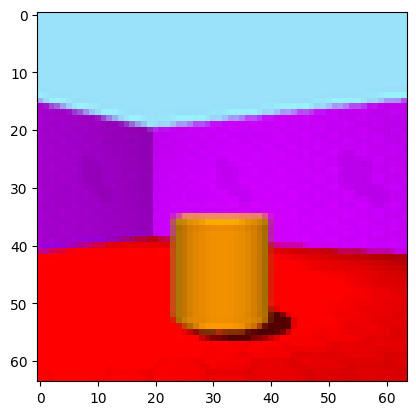

In [1]:
# picture
print(image)

# plot image
plt.imshow(image)
plt.show()

And here is a caption that goes with this picture.



In [1]:
# ground-truth caption
print(caption_text)

There are actually long and short captions for each image.
We have created an instance of the data set with one random long caption per image.
We can inspect the full list of short captions like so:



In [1]:
# Retrieve all short-captions for the image ID:
all_short_caps = A3DS_dataset.get_labels_for_image(itemID, caption_type='short')
for c in all_short_caps:
    print(c)

#+begin_example
there is a small cylinder
there is a orange cylinder
there is a cylinder in the left corner
there is a cylinder in front of a purple wall
there is a cylinder on red floor
there is a small cylinder in the left corner
there is a small cylinder in front of a purple wall
there is a small cylinder on red floor
there is a orange cylinder in the left corner
there is a orange cylinder in front of a purple wall
there is a orange cylinder on red floor
a small cylinder
a orange cylinder
a cylinder in the left corner
a cylinder in front of a purple wall
a cylinder on red floor
a small cylinder in the left corner
a small cylinder in front of a purple wall
a small cylinder on red floor
a orange cylinder in the left corner
a orange cylinder in front of a purple wall
a orange cylinder on red floor
the cylinder is in the left corner
the cylinder is in front of a purple wall
the cylinder is on red floor
the cylinder is small
the cylinder is orange
#+end_example

And similarly for the long captions.



In [1]:
# Retrieve all long-captions for the image ID:

all_long_caps = A3DS_dataset.get_labels_for_image(itemID, caption_type='long')
for c in all_long_caps:
    print(c)

#+begin_example
a small orange cylinder in the left corner in front of a purple wall on red floor
a small orange cylinder in the left corner on red floor in front of a purple wall
a small orange cylinder on red floor in the left corner in front of a purple wall
a small orange cylinder on red floor in front of a purple wall in the left corner
the picture shows a small orange cylinder in the left corner in front of a purple wall on red floor
the picture shows a small orange cylinder in the left corner on red floor in front of a purple wall
the picture shows a small orange cylinder on red floor in the left corner in front of a purple wall
the picture shows a small orange cylinder on red floor in front of a purple wall in the left corner
a small orange cylinder located in the left corner in front of a purple wall on red floor
a small orange cylinder located in the left corner on red floor in front of a purple
a small orange cylinder located on red floor in the left corner in front of a pur

Finally, let&rsquo;s also have a look at the vocabulary for this A3DS data set:



In [1]:
vocab = A3DS_dataset.vocab["word2idx"].keys()
print("VOCAB: ", vocab)

vocab_size = len(vocab)
print("VOCAB SIZE: ", vocab_size)

VOCAB:  dict_keys(['START', 'END', 'UNK', 'PAD', 'a', 'tiny', 'red', 'block', 'in', 'the', 'right', 'corner', 'front', 'of', 'wall', 'on', 'floor', 'picture', 'shows', 'standing', 'is', 'close', 'to', 'side', 'near', 'middle', 'nearly', 'left', 'cylinder', 'ball', 'pill', 'small', 'medium', 'sized', 'big', 'large', 'huge', 'giant', 'orange', 'yellow', 'light', 'green', 'dark', 'cyan', 'blue', 'purple', 'pink'])
VOCAB SIZE:  47

We see that this vocabulary is actually pretty small.



### Creating a &rsquo;DataLoader&rsquo;



Let&rsquo;s create a &rsquo;DataLoader&rsquo; for batches of a specified size, using a random shuffle of the data.



In [1]:
batch_size = 50
A3DS_data_loader = torch.utils.data.DataLoader(
    dataset    = A3DS_dataset,
    batch_size = batch_size,
    shuffle    = True,
)

## The (pre-trained) LSTM NIC



Definition of the LSTM-based neural image captioner as an instance of PyTorch&rsquo;s &rsquo;nn.Module&rsquo;:



In [1]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, visual_embed_size, batch_size=1, num_layers=1):
        """
        Initialize the language module consisting of a one-layer LSTM and
        trainable embeddings. The image embeddings (both target and distractor!)
        are used as additional context at every step of the training
        (prepended to each word embedding).

        Args:
        -----
            embed_size: int
                Dimensionality of trainable embeddings.
            hidden_size: int
                Hidden/ cell state dimensionality of the LSTM.
            vocab_size: int
                Length of vocabulary.
            visual_embed_size: int
                Dimensionality of each image embedding to be appended at each time step as additional context.
            batch_size: int
                Batch size.
            num_layers: int
                Number of LSTM layers.
        """
        super(DecoderRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embed_size= embed_size
        self.vocabulary_size = vocab_size
        self.visual_embed_size = visual_embed_size
        # embedding layer
        self.embed = nn.Embedding(self.vocabulary_size, self.embed_size)
        # layer projecting ResNet features of a single image to desired size
        self.project = nn.Linear(2048, self.visual_embed_size)

      # LSTM takes as input the word embedding with prepended embeddings of the two images at each time step
        # note that the batch dimension comes first
        self.lstm = nn.LSTM(self.embed_size + 2*self.visual_embed_size, self.hidden_size , self.num_layers, batch_first=True)
        # transforming last lstm hidden state to scores over vocabulary
        self.linear = nn.Linear(hidden_size, self.vocabulary_size)

        self.batch_size = batch_size
        # initial hidden state of the lstm
        self.hidden = self.init_hidden(self.batch_size)

        # initialization of the layers
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)

    def init_hidden(self, batch_size):

        """
        At the start of training, we need to initialize a hidden state;
        Defines a hidden state with all zeroes
        The axes are (num_layers, batch_size, hidden_size)
        """
        # if torch.backends.mps.is_available():
        #     device = torch.device("mps")
        # elif torch.cuda.is_available():
        #     device = torch.device("cuda")
        # else:
        #     device = torch.device("cpu")
        device = torch.device('cpu')

        return (torch.zeros((1, batch_size, self.hidden_size), device=device), \
                torch.zeros((1, batch_size, self.hidden_size), device=device))

    def forward(self, features, captions, prev_hidden):
        """
        Perform forward step through the LSTM.

        Args:
        -----
            features: torch.tensor(batch_size, 2, embed_size)
                Embeddings of images, target and distractor concatenated in this order.
            captions: torch.tensor(batch_size, caption_length)
                Lists of indices representing tokens of each caption.
            prev_hidden: (torch.tensor(num_layers, batch_size, hidden_size), torch.tensor(num_layers, batch_size, hidden_size))
                Tuple containing previous hidden and cell states of the LSTM.
        Returns:
        ------
            outputs: torch.tensor(batch_size, caption_length, embedding_dim)
                Scores over vocabulary for each token in each caption.
            hidden_state: (torch.tensor(num_layers, batch_size, hidden_size), torch.tensor(num_layers, batch_size, hidden_size))
                Tuple containing new hidden and cell state of the LSTM.
        """

        # features of shape (batch_size, 2, 2048)
        image_emb = self.project(features) # image_emb should have shape (batch_size, 2, 512)
        # concatenate target and distractor embeddings
        img_features = torch.cat((image_emb[:, 0, :], image_emb[:, 1, :]), dim=-1).unsqueeze(1)
        embeddings = self.embed(captions)
        # repeat image features such that they can be prepended to each token
        img_features_reps = img_features.repeat(1, embeddings.shape[1], 1)
        # PREpend the feature embedding as additional context as first token, assume there is no END token
        embeddings = torch.cat((img_features_reps, embeddings), dim=-1)
        out, hidden_state = self.lstm(embeddings, prev_hidden)
        # project LSTM predictions on to vocab
        outputs = self.linear(out) # prediction shape is (batch_size, max_sequence_length, vocab_size)
        # print("outputs shape in forward ", outputs.shape)
        return outputs, hidden_state

    def log_prob_helper(self, logits, values):
        """
        Helper function for scoring the sampled token,
        because it is not implemented for MPS yet.
        Just duplicates source code from PyTorch.
        """
        values = values.long().unsqueeze(-1)
        values, log_pmf = torch.broadcast_tensors(values, logits)
        values = values[..., :1]
        return log_pmf.gather(-1, values).squeeze(-1)

    def sample(self, inputs, max_sequence_length):
        """
        Function for sampling a caption during functional (reference game) training.
        Implements greedy sampling. Sampling stops when END token is sampled or when max_sequence_length is reached.
        Also returns the log probabilities of the action (the sampled caption) for REINFORCE.

        Args:
        ----
            inputs: torch.tensor(1, 1, embed_size)
                pre-processed image tensor.
            max_sequence_length: int
                Max length of sequence which the nodel should generate.
        Returns:
        ------
            output: list
                predicted sentence (list of tensor ids).
            log_probs: torch.Tensor
                log probabilities of the generated tokens (up to and including first END token)
            raw_outputs: torch.Tensor
                Raw logits for each prediction timestep.
            entropies: torch.Tesnor
                Entropies at each generation timestep.
        """

        # placeholders for output
        output = []
        raw_outputs = [] # for structural loss computation
        log_probs = []
        entropies = []
        batch_size = inputs.shape[0]
        softmax = nn.Softmax(dim=-1)
        init_hiddens = self.init_hidden(batch_size)

        # if torch.backends.mps.is_available():
        #     device = torch.device("mps")
        # elif torch.cuda.is_available():
        #     device = torch.device("cuda")
        # else:
        #     device = torch.device("cpu")
        device = torch.device('cpu')

        #### start sampling ####
        for i in range(max_sequence_length):
            if i == 0:
                cat_samples = torch.tensor([0]).repeat(batch_size, 1)
                hidden_state = init_hiddens

            cat_samples = cat_samples.to(device)
            inputs = inputs.to(device)

            out, hidden_state = self.forward(inputs, cat_samples, hidden_state)
            
            # get and save probabilities and save raw outputs
            raw_outputs.extend(out)
            probs = softmax(out)

            max_probs, cat_samples = torch.max(probs, dim = -1)
            log_p = torch.log(max_probs)
            entropy = -log_p * max_probs

            top5_probs, top5_inds = torch.topk(probs, 5, dim=-1)

            entropies.append(entropy)
            output.append(cat_samples)
            # cat_samples = torch.cat((cat_samples, cat_samples), dim=-1)
            # print("Cat samples ", cat_samples)
            log_probs.append(log_p)


        output = torch.stack(output, dim=-1).squeeze(1)
        # stack
        log_probs = torch.stack(log_probs, dim=1).squeeze(-1)
        entropies = torch.stack(entropies, dim=1).squeeze(-1)

        ####
        # get effective log prob and entropy values - the ones up to (including) END (word2idx = 1)
        # mask positions after END - both entropy and log P should be 0 at those positions
        end_mask = output.size(-1) - (torch.eq(output, 1).to(torch.int64).cumsum(dim=1) > 0).sum(dim=-1)
        # include the END token
        end_inds = end_mask.add_(1).clamp_(max=output.size(-1)) # shape: (batch_size,)
        for pos, i in enumerate(end_inds):
            # zero out log Ps and entropies
            log_probs[pos, i:] = 0
            entropies[pos, i:] = 0
        ####

        raw_outputs = torch.stack(raw_outputs, dim=1).view(batch_size, -1, self.vocabulary_size)
        return output, log_probs, raw_outputs, entropies

Instantiate the module (with appropriate specs), load weights and instantiate weights with pre-trained weights.



In [1]:
# decoder configs
embed_size = 512
visual_embed_size = 512
hidden_size = 512

decoder = DecoderRNN(embed_size, hidden_size, vocab_size, visual_embed_size)

# Load the trained weights.
decoder_file = "A3DS/pretrained_decoder_3dshapes.pkl"
decoder.load_state_dict(torch.load(decoder_file))

<All keys matched successfully>

In [1]:
itemID=0
image, target_feats, caption_text, numeric_lbl, caption_indx = A3DS_dataset.__getitem__(itemID)
print(caption_indx)

tensor([ 0,  9, 38, 28,  8,  9, 27, 11, 15,  6, 16,  8, 12, 13,  4, 45, 14, 20,
        31,  1,  3,  3,  3,  3,  3,  3])
hi!

The current NIC module was actually trained for later use of two pictures (contrastive image captioning).
Therefore, we need to input the picture to be described not once, but twice.
(This is otherwise completely innocuous for our current purposes of single-picture captioning.)



In [1]:
target_features = target_feats.reshape(1,len(target_feats))
both_images     = torch.cat((target_features.unsqueeze(1), target_features.unsqueeze(1)), dim=1)
output, _, _, _ = decoder.sample(both_images, caption_indx.shape[0])

def clean_sentence(output):
    """
    Helper function for visualization purposes.
    Transforms list of token indices to a sentence.
    Also accepts mulit-dim tensors (for batch size > 1).

    Args:
    ----
    output: torch.Tensor(batch_size, sentence_length)
        Tensor representing sentences in form of token indices.

    Returns:
    -------
    sentence: str
        String representing decoded sentences in natural language.
    """
    list_string = []
    for idx in output:
        for i in idx:
            try:
                list_string.append(A3DS_dataset.vocab["idx2word"][i.item()])
            except ValueError:
                for y in i:
                    list_string.append(A3DS_dataset.vocab["idx2word"][y.item()])
    sentence = ' '.join(list_string) # Convert list of strings to full string
    sentence = sentence.capitalize()  # Capitalize the first letter of the first word
    # find index of end token for displaying
    if "end" in sentence:
        len_sentence = sentence.split(" ").index("end")
    else:
        len_sentence = len(sentence.split(" "))
    cleaned_sentence = " ".join(sentence.split()[:len_sentence])
    return(cleaned_sentence)

print(clean_sentence(output))

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 8.1.1: </span></strong>
>
> 0. [Just for yourself] Try out different images and generate captions for them. Try to get a feeling for how reliable or good they are. Try to figure out what criteria you use when you intuitively judge a caption as good. Think about what &rsquo;goodness&rsquo; of a generated caption means (also in relation to the ground truth in the training set).
>
> 1. Describe the architecture of the decoder module that is used in in direct comparison to the set up from the paper [Vinyals et al. (2015)](https://arxiv.org/abs/1411.4555). Highlight at least two differences in model architecture between the decoder model used here and that of Vinyals et al. These differences should all be *major* differences, i.e., differences that *could* plausible have a strong impact on the quality of the results. I.o.w., do not mention trivialities.
>
> 2. Name at least two things that would be important to know for a direct, close reproduction of Vinyals et al. results that are not or only insufficiently described in the paper.

